# Crime Monthly Rhythm Maps

This analysis will examine six years of data that was aggregated by SANDAG and processed by the [San Diego Regional Data Library](http://sandiegodata.org) to visualize crime patterns on a weekly and hourly basis. The analysis uses 797,978 crime incidents. The data is published in CSV and shapefile form at the [Library's data repository](http://data.sandiegodata.org/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract)

These heat maps, also know as rhythm maps,  are square grids where each hour of the week is represented by a cell. The vertical axis is hour of day, and the horizontal axis is day of week, with Sunday being the area between 0 and 1, etc.  The color indicates the number of crimes in that hour of the week, with red being larger than yellow. Note that each grid is scaled independently, so a red square in one heatmap is not comparable to a red square in another heatmap. This visualization is only for looking at the paterns of crimes over time; it doesn't tell you anything about the number of crimes, except the relative relationship between hours in a single grid.

There are three types of incidents:
* Crime Cases
* Arrests
* Citations

However, this version of the dataset doesn't have the column from the original dataset that has these values, so this analysis will include all of them. 

There are 12 crime categories, expressed as the codes established by the FBI. ( UCR codes. )

First we will look at all of the incidents in the city, and then by each type. A grid is blank when there are fewer than 40 incidents of that  type and category. 


In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
incidents_url='https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-5y.csv'
# 100K set, for testing. 
#incidents_url = 'https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-100k.csv'
inct = pd.read_csv(incidents_url)

inct['time'] = pd.to_datetime(inct.time)
inct['date'] = pd.to_datetime(inct.date)
inct['id'] = inct.index # Legacy of earlier dataset

In [3]:
inct.head().T

,0,1,2,3,4
id,0,1,2,3,4
date,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00
year,2008,2008,2008,2008,2008
month,1,1,1,1,1
day,2922,2922,2922,2922,2922
week,0,0,0,0,0
dow,2,2,2,2,2
time,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00
hour,0,0,0,0,0
is_night,1,1,1,1,1


In [5]:
inct['dtime'] = inct['hour'].astype('float64') + inct.time.dt.minute/60.0
inct['qtime'] = (inct['dtime'] * 4).astype('int')

inct['legend'] = inct.type # Legacy

legends = [u'ASSAULT',u'ROBBERY',u'VEHICLE BREAK-IN/THEFT', u'BURGLARY',
        u'THEFT/LARCENY',u'SEX CRIMES',u'DRUGS/ALCOHOL VIOLATIONS',u'DUI']

legends

In [25]:
#
# Build a function for creating Rhythm Map plots, with common options
#
from math import ceil

def plot_rhythm(df, legends = None, communities = None, incident_type=None, title=None, filename=None,
                axes_fields=['year','week'], ncols  = 2, scale = 1.0, height=2.5):
    
    import numpy as np
    import matplotlib.pyplot as plt

    if not legends:
        legends = sorted([ l for l in df.legend.unique() if l.strip() and l not in ('-', 'ARSON','HOMICIDE') ])

    if not communities:
        communities = [None]

    
    nonnull_l_len = max(len([l for l in legends if l is not None]), 1)
    nonnull_c_len = max(len([ c for c in communities if c is not None]), 1)
   
    c = nonnull_l_len * nonnull_c_len

    nrows = ceil(float(c)/ncols)

    cmap = plt.get_cmap('YlOrRd', 500)

    fig, axes = plt.subplots(nrows=int(nrows), ncols=int(ncols), figsize=(10,10), 
                             squeeze=True, sharex=False, sharey=False)

    try:
        len(axes)
        axes = axes.ravel() # Convert 2D array to 1D
    except TypeError :
        axes = [axes] # subplot returns scalar in c=1 case. 

    
    fig.set_size_inches(12.0*scale,nrows*height*scale)
    
    plt.tight_layout(h_pad=2)
    fig.subplots_adjust(top=0.90)
    i = 0
    
    for community in communities:
        for legend in legends:

            sub = df
            gtitles = []
            
            if legend:
                sub = sub[sub.legend == legend]
                
                gtitles.append(legend.title())

            if community:
                sub = sub[sub.community == community]
                gtitles.append(community)
                
            if incident_type:
                # The type field used to be for CITATIONS, ARREST, etc, but
                # seems to be gone in this version of the dataset. 
                #sub = sub[sub.type == incident_type]
                pass

            
            axes[i].set_title(' / '.join(gtitles))

            if len(sub) < 40:
                i += 1
                continue

            heatg = sub.groupby(axes_fields)
           
            hgcounts = heatg.count()['id'].unstack(axes_fields[0]).fillna(0)

            # Converting to an array puts it into a for that
            # matplotlib expects. This probably only works b/c the
            # hours and days of week are 1-based indexes. 
            axes[i].pcolormesh(np.array(hgcounts.T),cmap=cmap)
            
            i += 1
            
        
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')
        
    if filename:
        fig.savefig(filename)
        


# Hour vs Week of Year By Major Crime Type

These maps show the hour of the day on the vertical axis and week of year on the horizonal, with all of the years in the dataset combined. The maps clearly show a 5AM daily lull, and a spike in DUIs in the middle of the summer. 


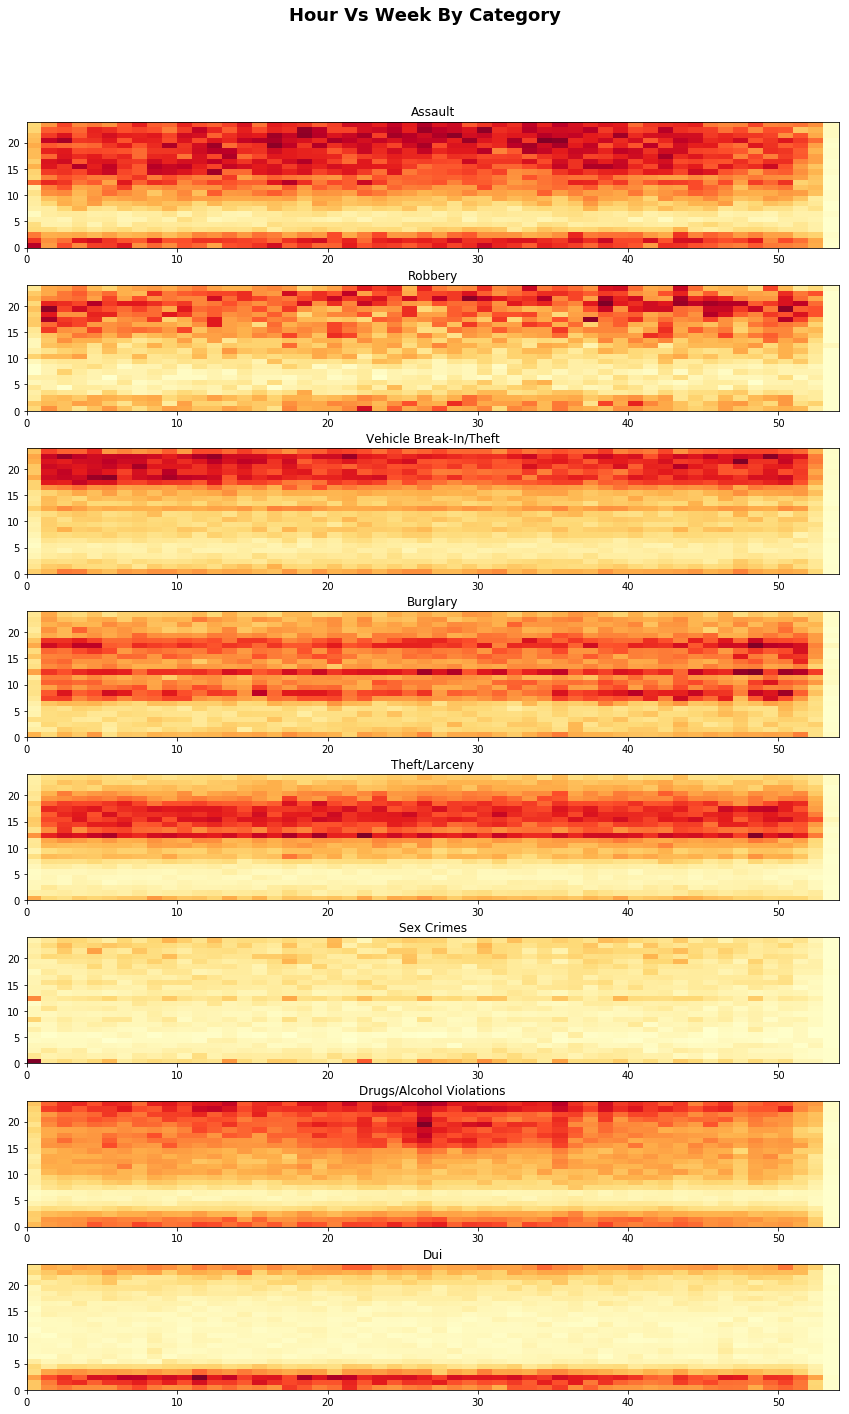

In [9]:
plot_rhythm(inct, ncols = 1, axes_fields=['hour','week'], legends=legends,
            title = "Hour Vs Week By Category")

# Week of Year by Data Year

With a vertical axis of the year of the data, these maps plot one box per week for all weeks in the dataset. THe most significant patter is the reduction in DUI and Alcohol crimes in the later years. 


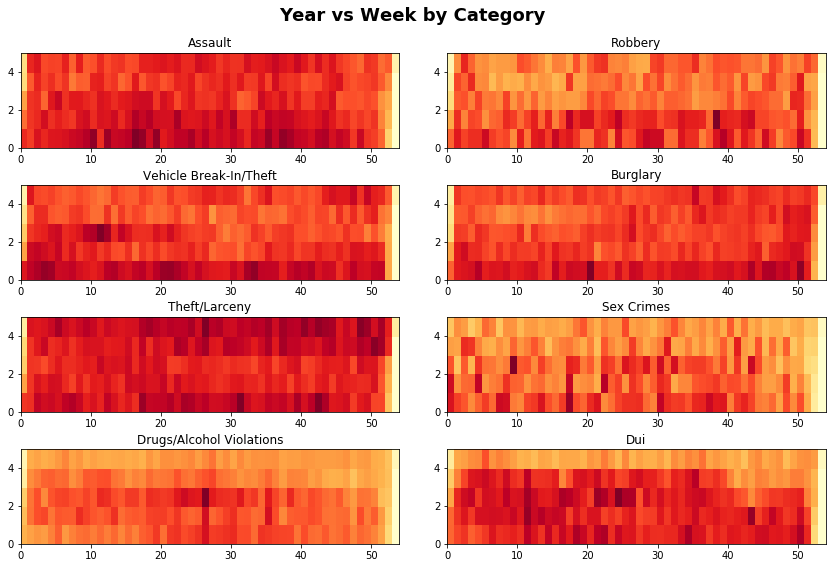

In [10]:
plot_rhythm(inct, ncols = 2, axes_fields=['year','week'], legends=legends, height=2,
            title = 'Year vs Week by Category')

In 'Year vs Week by Category', the years run from 2006 to 2013, where '7' is 2013. 

# Hour of Day Vs Week of Year, for Pacific Beach

These maps show a seasonal rhythm, with the strongest being the cluster of alcohol crimes  in the afternoon and evenings in the summer. 


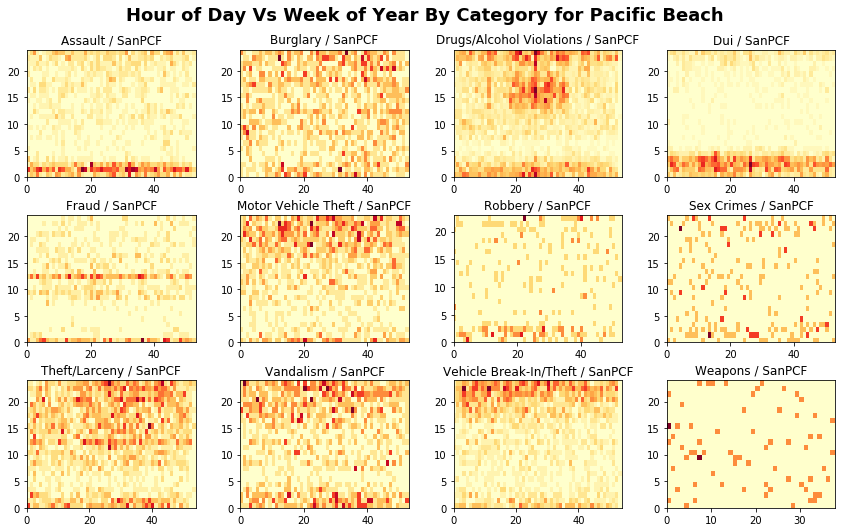

In [11]:
plot_rhythm(inct, ncols = 4, communities = ['SanPCF'], axes_fields=['hour','week'],
            title = 'Hour of Day Vs Week of Year By Category for Pacific Beach')

In [13]:
communities = ['SanDOW','SanMDC','SanPCF','SanSOT','SanGRE','SanCLA','SanUPT','SanENC','SanUNV','SanMID',
               'SanMIR','SanSKY','SanOAT', 'SanCOL', 'SanLAJ']
all_communities = list(inct['community'].unique())
drug_communities = ['SanPCF','SanMSS','SanUNV','SanMSH','SanOCN','SanMIS']
assault_communities = ['SanENC', 'SanMDC', 'SanPCF', 'SanDOW', 'SanGRE']
sex_communities = ['SanDOW', 'SanMDC', 'SanGRE', 'SanCOL', 'SanMDS', 'SanBAR' ]

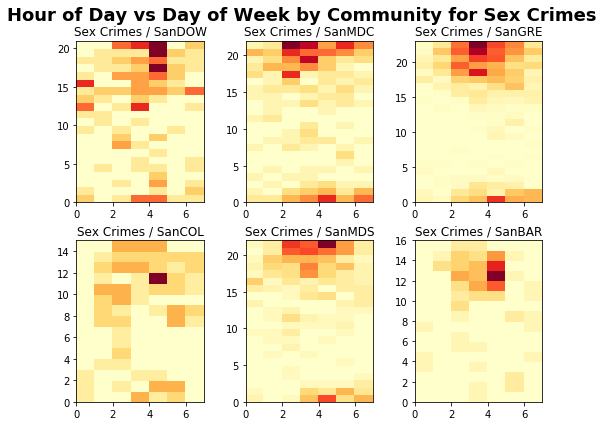

In [14]:
plot_rhythm(inct[inct.desc == 'PROSTITUTION' ], ncols = 3, height=5, scale = .6, 
            legends = ['SEX CRIMES'], 
            communities=sex_communities, axes_fields=['hour','dow'],
            title = 'Hour of Day vs Day of Week by Community for Sex Crimes')

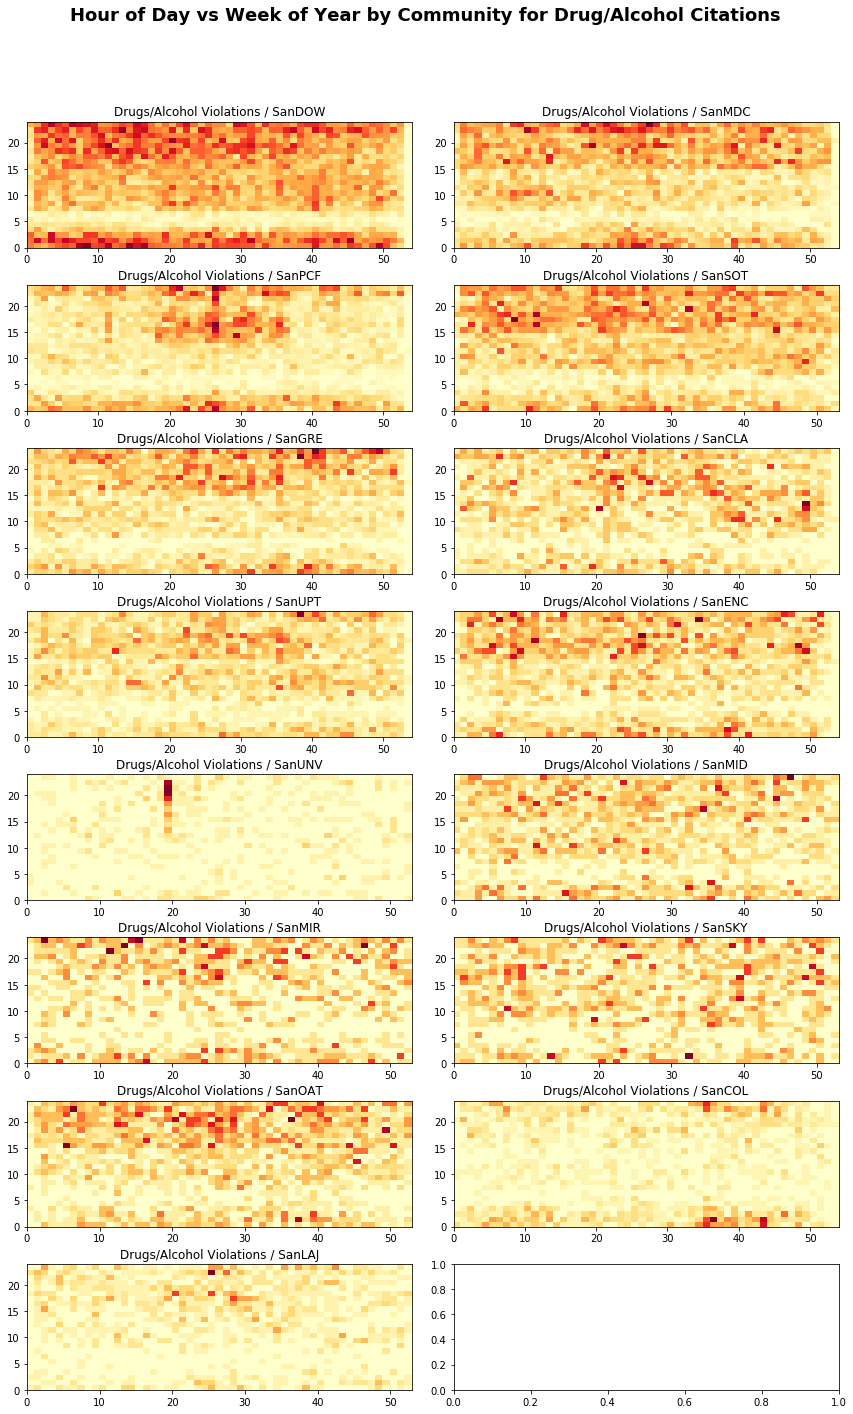

In [15]:
plot_rhythm(inct, ncols = 2, legends = ['DRUGS/ALCOHOL VIOLATIONS'], communities=communities, 
            axes_fields=['hour','week'], incident_type='CITATION',
            title = 'Hour of Day vs Week of Year by Community for Drug/Alcohol Citations')

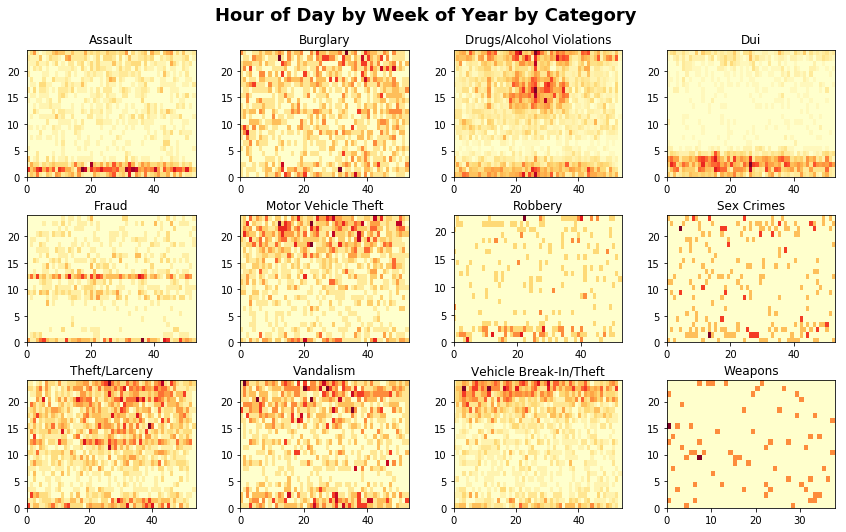

In [16]:
plot_rhythm(inct[inct.community == 'SanPCF'], ncols = 4, 
            axes_fields=['hour','week'], title = 'Hour of Day by Week of Year by Category')

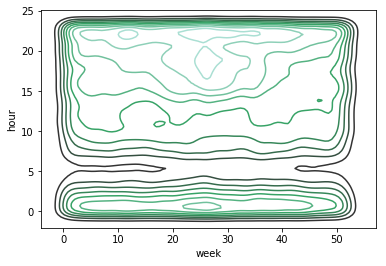

In [17]:
import seaborn as sns

x = inct[inct.legend == 'DRUGS/ALCOHOL VIOLATIONS']

sns.kdeplot(x.week, x.hour,title = 'Drug / Alcohol');


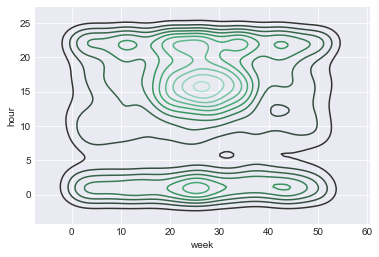

In [18]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanPCF')]
sns.set_style("darkgrid")
sns.kdeplot(x.week, x.hour, title = 'Drug / Alcohol for Pacific Beach');

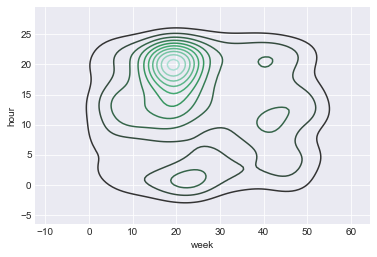

In [19]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanUNV')]

sns.kdeplot(x.week, x.hour, title='Drugs/Alcohol for UCSD area');

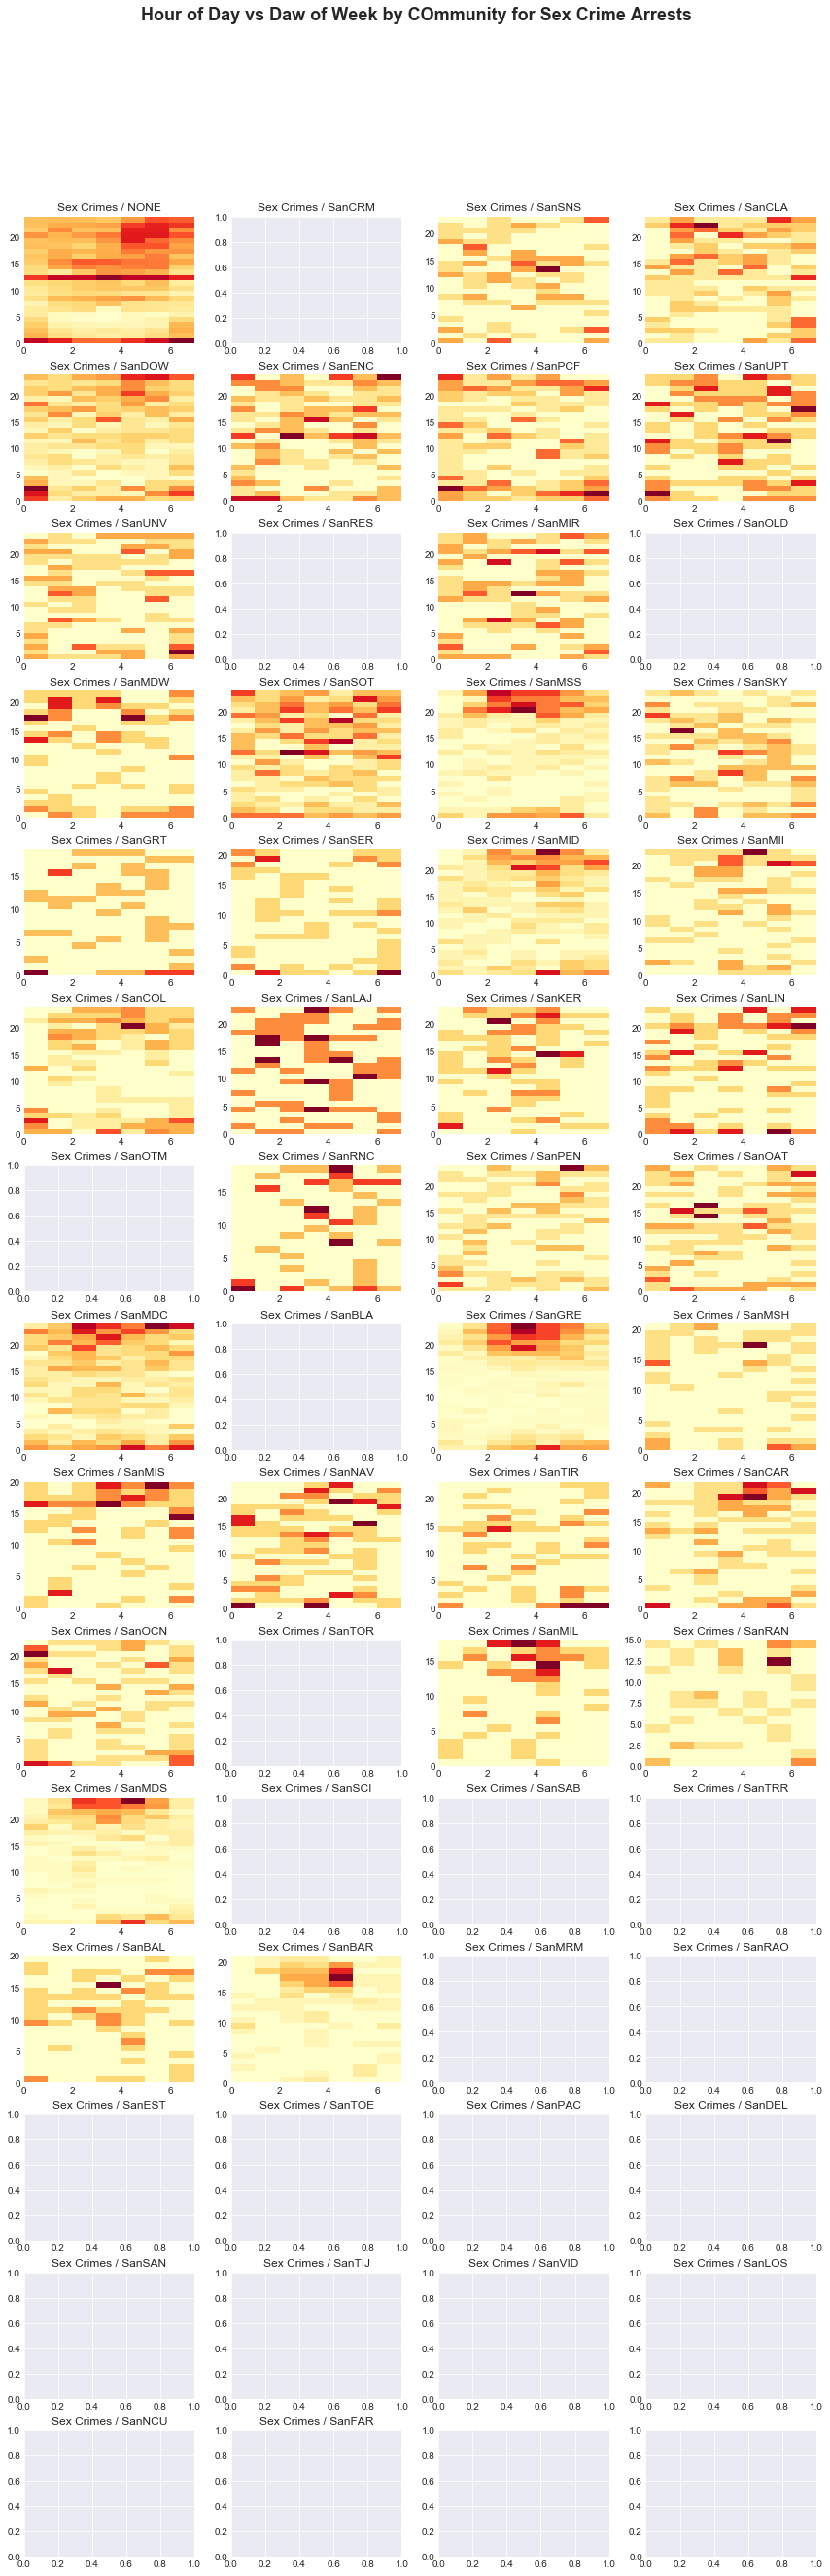

In [20]:
plot_rhythm(inct, ncols = 4, legends = ['SEX CRIMES'], communities=all_communities, 
            axes_fields=['hour','dow'], incident_type='ARREST',
            title = 'Hour of Day vs Daw of Week by COmmunity for Sex Crime Arrests')

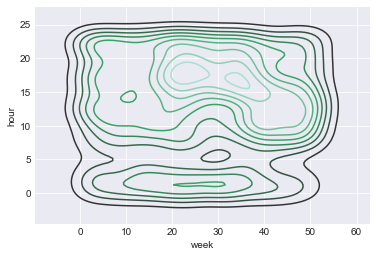

In [21]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanCLA')]

sns.kdeplot(x.week, x.hour, title = 'Drugs/Alcohol for Clairemont');

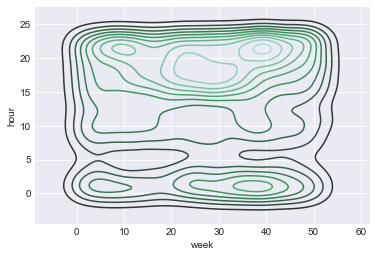

In [22]:
x = inct[(inct.legend == 'DRUGS/ALCOHOL VIOLATIONS') & (inct.community == 'SanGRE')]

sns.kdeplot(x.week, x.hour,title = 'Drug / Alcohol for North Park');